# 0. 객체탐지(b-box) 모델을 조사
- 조사한 모델이 예상 성능 요구 사항을 충족시킬 수 있는지 확인해주세요. 확인한 내용을 **PPT 1장~3장**으로 정리해서 제출해주세요.
- 모델의 라이센스, 오픈 모델의 성능을 파악해서 왜 해당 모델을 선택했는지 작성이 되어야합니다.
- 업무요청 가이드에서는 yolov5 모델을 baseline모델로 사용하라고 되어있지만, 다른 b-box 모델을 조사했을 때 더 좋은 성능의 모델이 있다면 그 모델로 진행해도 좋습니다.


# 데이터셋 구축
- 아래의 코드 가이드를 참고해서 데이터셋 구축하는 코드를 작성해주세요
- 완료된 데이터셋 구축 코드는 **.ipynb 파일을 다운해서 제출**해주세요.

# 1. Import Library
- 코드에 사용되는 파이썬 라이브러리를 불러옵니다.

In [3]:
import os
import cv2
import glob
import shutil
import warnings
import matplotlib.pyplot as plt

from tqdm.auto import tqdm       # 작업 진행 속도를 보는데 유용한 라이브러리입니다.
from sklearn.model_selection import train_test_split

c:\Users\piano\anaconda3\envs\hyojung_2015479\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# warning 무시 코드
warnings.filterwarnings(action='ignore')

In [19]:
# 현재 실행 파일 경로 확인
os.getcwd()

'a:\\바탕화면\\코멘토 직무체험'

# 2. 데이터셋 준비
- 데이콘의 데이터셋은 차종으로 라벨링 되어 있는데, 우리는 차 종류를 객체탐지하는 것이 아닌 "차"를 객체탐지하는 것이 목표입니다.
- 차 종류로 라벨링 된 text파일 데이터를 수정해야합니다.

In [4]:
# 기존에 존재하던 데이터셋 폴더 경로 정의
origin_dir = r'A:\바탕화면\코멘토 직무체험\data\train'  # ex: '/content/drive/MyDrive/comento/1/dataset/data'

# 원본 라벨파일(.txt) 불러오기
origin_label = f'{origin_dir}/*.txt'
label_txts = glob.glob(origin_label)

print('라벨파일(.txt) 개수 : ',len(label_txts))

라벨파일(.txt) 개수 :  6481


In [5]:
# 수정된 라벨을 저장하는 폴더 경로 정의
edit_label_dir = r'A:\바탕화면\코멘토 직무체험\data\label_data' # ex: '/content/drive/MyDrive/comento/1/dataset/label_data'

# 수정된 라벨링 데이터 저장 폴더를 생성
if not os.path.exists(edit_label_dir):
    os.mkdir(edit_label_dir)

# 3. Yolo 모델링을 위한 라벨링 데이터 수정
- 모든 데이터의 라벨을 "car"로 변경해야합니다.
- 기존 데이터셋의 Labelme 형태를 yolo format을 따라 라벨링 파일을 변경해야합니다.
- 참고 자료: https://docs.ultralytics.com/datasets/detect/#ultralytics-yolo-format


### 코드 설계 참고
- 코드를 작성하기 전에 구현하고자하는 로직을 텍스트로 설계해보는 연습도 많이 하면 좋을 것 같습니다.
1. 기존의 모든 라벨 데이터를 읽기모드로 불러와서 반복문으로 데이터 파일을 하나씩 열어줍니다.
2. 1번에서 불러온 라벨데이터(.txt)는 Labelme 형태로 <classId, x1, y1, x2, y2, x3, y3, x4, y4>에 맞게 값을 따로 정의해줍니다.
  - 참고 : strip().split(' ') 라이브러리 활용 가능
3. 모든 데이터의 라벨을 "car" 하나로만 변경해야하므로, classId는 0으로 변경해주세요
4. 2번에서 불러온 좌표값들을 활용하여 yolo 라벨 형태에 맞게 중심좌표와 너비/높이를 계산해줍니다.
5. 수정된 라벨을 새로운 파일로 저장해줍니다. (라벨 파일명은 매칭되는 이미지파일명과 동일해야합니다.)

In [7]:
# 이미지 크기 알아내기
from PIL import Image
image_width = Image.open(r'A:\바탕화면\코멘토 직무체험\data\train\syn_00000.png').size[0]
image_height = Image.open(r'A:\바탕화면\코멘토 직무체험\data\train\syn_00000.png').size[1]

print(image_width, image_height)

1920 1040


In [10]:
# 라벨 데이터 수정 코드 작성

# 작업 경로 지정
data_dir = r'a:\바탕화면\코멘토 직무체험\data\train'
output_dir = r'a:\바탕화면\코멘토 직무체험\data\label_data'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#원본 라벨 파일 불러오기
label_files=glob.glob(os.path.join(data_dir,'*.txt'))


for label_file in label_files:
    # 파일명에서 확장자 제거(이미지 파일명과 동일하게 하기 위함)
    img_name=os.path.splitext(os.path.basename(label_file))[0]

    # 1. 이미지 파일에서 이미지 크기 가져오기 
    # (1920, 1040)임을 알고 있지만 연습 겸 혹시나 다른 크기가 들어올 수도 있으니 코드 작성함.
    img_path=os.path.join(data_dir, img_name + '.png')
    img = Image.open(img_path)
    image_width, image_height = img.size

    # 2. 라벨 파일을 읽어서 라벨 데이터 파싱 
    with open(label_file, 'r') as f:
        lines=f.readlines()

    new_labels = []

    for line in lines:
        # <classid, x1, y1, x2, y2, x3, y3, x4, y4>로 데이터 분리
        data=line.strip().split(' ')
        classid = 0  # 항상 class는 0("car")

        #Labelme 형식 좌표 
        x1, y1, x2, y2, x3, y3, x4, y4 = map(float, data[1:9])

        # Yolo 형식 좌표 및 width height 계산 (center들은 중심좌표 계산)
        xcenter= (x1+x3)/2/image_width # 중심좌표 계산 및 표준화
        ycenter= (y1+y3)/2/image_height 
        width= abs(x2-x1)/image_width
        height= abs(y3-y1)/image_height

        # Yolo 형식으로 라벨 데이터 만들기 (classid, xcenter, ycenter, width, height)
        new_label = f'{classid} {xcenter:.6f} {ycenter:.6f} {width:.6f} {height:.6f}' #소수점 6자리까지
        new_labels.append(new_label)

    # 3. 새로운 라벨 파일로 저장 
    output_file=os.path.join(output_dir, img_name + '.txt')
    with open(output_file, 'w') as out_f:
        out_f.write('\n'.join(new_labels))


print("라벨 형식 변환이 완료됨")

라벨 형식 변환이 완료됨


# 4. 라벨이 제대로 수정되었는지 확인하기
- 아래 함수를 통해 라벨이 제대로 수정되었는지 시각화해서 확인해주세요.
- 항상 작업을 완료후에는 결과를 확인하면서 이슈가 없는지 파악해야합니다.

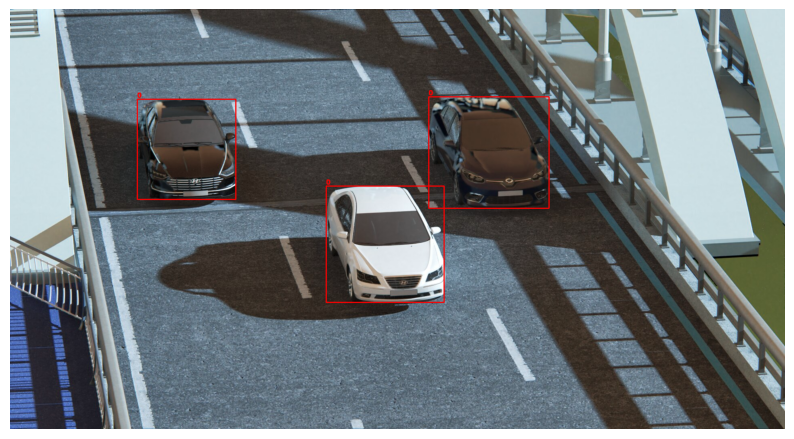

In [17]:
import numpy as np
def draw_boxes_on_image(image_path : str, annotation_path : str,
                        img_width : int, img_height : int):
    ''' 이미지와 바운딩 박스를 그리는 함수
    Args:
        image_path (str): 이미지 파일 경로
        annotation_path (str): 라벨 파일 경로 (.txt)
        img_width (int): 이미지의 너비
        img_height (int): 이미지의 높이
    Returns:
        show image: 이미지와 바운딩 박스가 그려진 이미지
    '''
    # 이미지 불러오기
    #image = cv2.imread(image_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Pillow로 이미지 불러오기 (한글 경로 문제 해결)
    pil_image = Image.open(image_path)
    image = np.array(pil_image)  # Pillow 이미지를 numpy 배열로 변환
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # OpenCV 형식(BGR)으로 변환

    # txt 파일에서 Class ID와 Bounding Box 정보 읽기
    with open(annotation_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        values = list(map(float, line.strip().split(' ')))
        class_id = int(values[0])

        # YOLO 형식의 좌표를 원래 이미지 크기에 맞게 변환
        x_center = values[1] * img_width
        y_center = values[2] * img_height
        box_width = values[3] * img_width
        box_height = values[4] * img_height

        # 좌표 계산
        x_min = int(round(x_center - (box_width / 2)))
        y_min = int(round(y_center - (box_height / 2)))
        x_max = int(round(x_center + (box_width / 2)))
        y_max = int(round(y_center + (box_height / 2)))

        # 이미지에 바운딩 박스 그리기
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.putText(image, str(class_id), (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # 이미지와 바운딩 박스 출력
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')  # 축 숨기기
    plt.show()


#### 검증 함수 실행!!
image_file = os.path.join(origin_dir, 'syn_00068.png')
annotation_file = os.path.join(edit_label_dir, 'syn_00068.txt')
img_width, img_height = Image.open(image_file).size

draw_boxes_on_image(image_file, annotation_file, img_width, img_height)

# 5. train/valid/test set 분리
- 간단한 데이터셋 통계량 확인하고, 데이터셋 비율을 정해줍니다.
  - 차량 데이터 총 개수 확인 (참고 : glob 모듈 사용)
- 학습/검증/테스트셋 분리
  - train_test_split 라이브러리를 활용하여 test_size 인자로 데이터셋 비율을 조절할 수 있습니다. (train_test_split라이브러리는 데이터셋을 분리하는데에 많이 사용되고 있습니다.)
  - trainset : validset : testset  = 6 : 2 : 2

In [31]:
# 학습/검증/테스트셋 분리

# 1. 데이터셋 통계 확인 및 차량 데이터 총 개수 확인
image_dir = r'A:\바탕화면\코멘토 직무체험\data\train'
label_dir = r'A:\바탕화면\코멘토 직무체험\data\label_data'

# 이미지와 라벨 파일 목록 가져오기
image_files= glob.glob(os.path.join(image_dir, '*.png'))
label_files= glob.glob(os.path.join(label_dir, '*.txt'))

# 데이터 통계량 확인
total_images=len(image_files)
total_labels=len(label_files)
print(f"총 이미지 파일 개수: {total_images}")
print(f"총 라벨 파일 개수: {total_labels}")


# 2. 학습/검증/테스트 분리 (6:2:2)
# train과 val+test 분리
train_images, val_test_images, train_labels, val_test_labels = train_test_split(
    image_files, label_files, test_size=0.4, random_state=10)

# val+test에서 val과 test로 분리
valid_images, test_images, valid_labels, test_labels = train_test_split(
    val_test_images, val_test_labels, test_size=0.5, random_state=10)


# 3. 결과 확인
print(f"학습데이터 수: {len(train_images)}")
print(f"검증데이터 수: {len(valid_images)}")
print(f"테스트데이터 수: {len(test_images)}")

# 각 데이터셋 파일명을 확인해보고 싶다면 출력
print(f"학습 데이터 예시: {train_images[:5]}")
print(f"학습 데이터 예시: {train_labels[:5]}")
print(f"검증 데이터 예시: {valid_images[:5]}")
print(f"테스트 데이터 예시: {test_images[:5]}")

총 이미지 파일 개수: 6481
총 라벨 파일 개수: 6481
학습데이터 수: 3888
검증데이터 수: 1296
테스트데이터 수: 1297
학습 데이터 예시: ['A:\\바탕화면\\코멘토 직무체험\\data\\train\\syn_00280.png', 'A:\\바탕화면\\코멘토 직무체험\\data\\train\\syn_01206.png', 'A:\\바탕화면\\코멘토 직무체험\\data\\train\\syn_00907.png', 'A:\\바탕화면\\코멘토 직무체험\\data\\train\\syn_05193.png', 'A:\\바탕화면\\코멘토 직무체험\\data\\train\\syn_03816.png']
학습 데이터 예시: ['A:\\바탕화면\\코멘토 직무체험\\data\\label_data\\syn_00280.txt', 'A:\\바탕화면\\코멘토 직무체험\\data\\label_data\\syn_01206.txt', 'A:\\바탕화면\\코멘토 직무체험\\data\\label_data\\syn_00907.txt', 'A:\\바탕화면\\코멘토 직무체험\\data\\label_data\\syn_05193.txt', 'A:\\바탕화면\\코멘토 직무체험\\data\\label_data\\syn_03816.txt']
검증 데이터 예시: ['A:\\바탕화면\\코멘토 직무체험\\data\\train\\syn_04249.png', 'A:\\바탕화면\\코멘토 직무체험\\data\\train\\syn_05485.png', 'A:\\바탕화면\\코멘토 직무체험\\data\\train\\syn_01223.png', 'A:\\바탕화면\\코멘토 직무체험\\data\\train\\syn_05660.png', 'A:\\바탕화면\\코멘토 직무체험\\data\\train\\syn_02091.png']
테스트 데이터 예시: ['A:\\바탕화면\\코멘토 직무체험\\data\\train\\syn_04716.png', 'A:\\바탕화면\\코멘토 직무체험\\data\\train\\syn_05031.png'

# 6. 학습용 train/valid/test 데이터셋 폴더 생성

- 위에서 분리한 train/valid/testset을 옮겨둘 폴더를 생성하고, 파일을 복사해서 옮겨줍니다.
- 아래의 폴더 구조로 만들어주세요.

```
└── datasets /
    ├── images /
        ├── train /
            ├── 1.png
            ├── 2.png
        ├── val /
            ├── 3.png
            ├── 4.png
        ├── test /
            ├── 5.png
            ├── 6.png
    ├── labels /
        ├── train /
            ├── 1.txt
            ├── 2.txt
        ├── val /
            ├── 3.txt
            ├── 4.txt
        ├── test /
            ├── 5.txt
            ├── 6.txt
```

- 데이터를 저장하고자 하는 곳으로 이동 (참고 : shutil.copy 라이브러리 사용)
- 참고 자료: https://docs.ultralytics.com/datasets/detect/#ultralytics-yolo-format
- 구글드라이브의 용량이 부족하다면 데이터를 조금 더 삭제해서 줄여도 괜찮습니다.

In [32]:
# 데이터셋 구축 코드 작성

# 폴더 생성 함수
def create_folders(base_dir):
    '''데이터셋 폴더 구조 생성하는 함수'''
    # images/train, images/val, images/test
    os.makedirs(os.path.join(base_dir, 'images', 'train'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'images', 'val'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'images', 'test'), exist_ok=True)

    #labels/train, labels/val, labels/test
    os.makedirs(os.path.join(base_dir, 'labels', 'train'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'labels', 'val'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'labels', 'test'), exist_ok=True)

# 파일 복사 함수
def copy_files(file_list, dest_dir):
    '''파일 목록을 지정된 디렉토리로 복사하는 함수'''
    for file in file_list:
        shutil.copy(file, dest_dir)


# 1. 데이터셋 저장할 경로 지정
base_dir = './datasets' 
create_folders(base_dir)


# 2. 분리된 파일 복사
# train 파일 복사
copy_files(train_images, os.path.join(base_dir, 'images', 'train'))
copy_files(train_labels, os.path.join(base_dir, 'labels', 'train'))

# val 파일 복사
copy_files(valid_images, os.path.join(base_dir, 'images', 'val'))
copy_files(valid_labels, os.path.join(base_dir, 'labels', 'val'))

# test 파일 복사
copy_files(test_images, os.path.join(base_dir, 'images', 'test'))
copy_files(test_labels, os.path.join(base_dir, 'labels', 'test'))
        

print("파일 복사 완료")

파일 복사 완료



- 학습에 사용되는 .yaml 파일을 아래 형식에 맞춰서 만들어줍니다.

```
names:
- car
nc: 1
path: "dataset_folder_root_path"
test: "test_image_dataset_folder_path"
train: "train_image_dataset_folder_path"
val: "validation_image_dataset_folder_path"
```

In [1]:
# yaml 파일 생성 코드 작성 후 저장
import yaml

# yaml 파일에 저장할 데이터
data = {
    'names': ['car'],
    'nc': 1,
    'path': 'A:/바탕화면/코멘토 직무체험/datasets',
    'train': 'A:/바탕화면/코멘토 직무체험/datasets/images/train',
    'val': 'A:/바탕화면/코멘토 직무체험/datasets/images/val',
    'test': 'A:/바탕화면/코멘토 직무체험/datasets/images/test'
}

# yaml 파일 생성
with open('dataset_config.yaml', 'w', encoding='utf-8') as file:
    yaml.dump(data, file, allow_unicode=True)  #경로에 한글이 포함되어 있어 옵션 사용함 

print("yaml 파일 생성이 완료됨")

yaml 파일 생성이 완료됨


In [4]:
# 경로 설정 (os.path.join 사용)
current_dir = os.getcwd() 
file_name = 'dataset_config.yaml'

yaml_path = os.path.join(current_dir,  file_name)

# 경로가 실제로 존재하는지 확인
if os.path.exists(yaml_path):
    print(f"'{yaml_path}' 파일이 존재합니다.")
else:
    print(f"'{yaml_path}' 파일을 찾을 수 없습니다.")

# YAML 파일 읽기
with open(yaml_path, 'r', encoding='utf-8') as f:
    data = yaml.full_load(f)

# 내용 출력
print(data)


'a:\바탕화면\코멘토 직무체험\dataset_config.yaml' 파일이 존재합니다.
{'names': ['car'], 'nc': 1, 'path': 'A:/바탕화면/코멘토 직무체험/datasets', 'test': 'A:/바탕화면/코멘토 직무체험/datasets/images/test', 'train': 'A:/바탕화면/코멘토 직무체험/datasets/images/train', 'val': 'A:/바탕화면/코멘토 직무체험/datasets/images/val'}
